## Multi-Class Image Classification

In [1]:
from fastai.vision.all import *

### Loading the Data

In [3]:
# download data
path = untar_data(URLs.PETS)

In [4]:
# set base path
Path.BASE_PATH = path

In [5]:
path.ls()

(#1) [Path('images')]

In [6]:
(path/"images").ls()

(#1050) [Path('images/Siamese_193.jpg'),Path('images/Abyssinian_225.jpg'),Path('images/Siamese_187.jpg'),Path('images/saint_bernard_111.jpg'),Path('images/saint_bernard_2.jpg'),Path('images/Siamese_150.jpg'),Path('images/Siamese_144.jpg'),Path('images/german_shorthaired_125.jpg'),Path('images/Ragdoll_189.jpg'),Path('images/american_pit_bull_terrier_66.jpg')...]

In [7]:
file_name = (path/"images").ls()[0]
file_name

Path('images/Siamese_193.jpg')

In [8]:
re.findall(r'(.+)_\d+.jpg$', file_name.name)

['Siamese']

In [18]:
using_attr(print, 'name')(file_name)

Siamese_193.jpg


In [24]:
# creating a datablock from files
pets_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_items=get_image_files,
                       splitter=RandomSplitter(seed=42),
                       get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                       item_tfms=Resize(460),
                       batch_tfms=aug_transforms(size=224, min_scale=.75))
data_loaders = pets_block.dataloaders(path/"images")

### Verify the Data

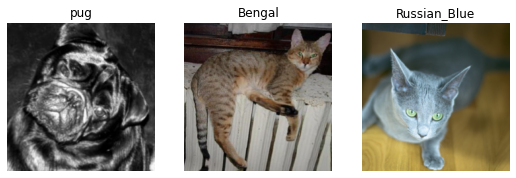

In [25]:
data_loaders.show_batch(nrows=1, ncols=3)

In [27]:
# display a summary of our datablock
pets_block.summary(path/"images")

Setting-up type transforms pipelines
Found 1050 items
2 datasets of sizes 840,210
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /Users/chhilty/.fastai/data/oxford-iiit-pet/images/shiba_inu_1.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/chhilty/.fastai/data/oxford-iiit-pet/images/shiba_inu_1.jpg
    applying partial gives
      shiba_inu
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(33))


Setting up after_item: Pipeline: Resize -- {'size': (460, 460), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 

### Train a Simple Model to Verify the Data

In [31]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [32]:
learn = cnn_learner(data_loaders, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,4.367107,1.283911,0.390476,04:58


epoch,train_loss,valid_loss,error_rate,time
0,1.500706,0.690803,0.228571,07:34
1,1.049748,0.572010,0.204762,08:39


### Cross-Entropy Loss

In [33]:
# get some data from the data loader
x, y = data_loaders.one_batch()

In [34]:
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [35]:
# inspect some predictions
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.3827e-03, 9.9567e-01, 4.0962e-06, 3.0786e-05, 1.8511e-04, 1.3146e-03,
        4.2228e-04, 2.0126e-05, 1.5040e-05, 1.3770e-04, 7.3368e-07, 3.9405e-04,
        6.8586e-07, 2.2939e-06, 7.1029e-06, 3.1147e-05, 3.6286e-05, 1.4723e-05,
        2.4083e-05, 3.1149e-05, 7.3363e-05, 6.9604e-06, 5.5126e-07, 2.8632e-05,
        1.6976e-06, 7.8314e-06, 1.1473e-05, 3.3144e-05, 1.3227e-05, 2.3535e-06,
        1.2845e-05, 8.9546e-06, 1.6451e-06, 6.5143e-06, 3.5486e-06, 3.9118e-05,
        1.9528e-05])

In [37]:
# the learner defaulted to cross-entropy therefore it sums to 1
len(preds[0]), preds[0].sum()

(37, tensor(1.))

#### Softmax

In [39]:
from plotting import plot_function

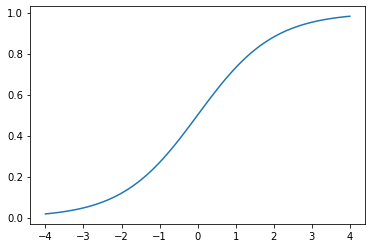

In [40]:
# remember what the sigmoid looks
plot_function(torch.sigmoid, min=-4, max=4)

In [41]:
# generate random data
torch.random.manual_seed(42)

random_numbers = torch.randn((6,2))*2
random_numbers

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [42]:
random_numbers.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [43]:
# now we take the relative difference as relative confidence
(random_numbers[:, 0]-random_numbers[:, 1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [44]:
# now we need a way to do this with more classes - welcome softmax

$Softmax(x) = \frac{e_x}{\sum{e^x}}$

In [45]:
sm_numbers = torch.softmax(random_numbers, dim=1)
sm_numbers

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

#### Log Likelihood

In [46]:
# suppose our targets are
targets = tensor([0,1,1,0,1,0])

In [48]:
# and our softmax output is
sm_numbers

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [49]:
# so we can pick our class probability like this
sm_numbers[range(6), targets]

tensor([0.6025, 0.4979, 0.8668, 0.9966, 0.4041, 0.3661])

In [53]:
# not for the loss, lower is better so...
-sm_numbers[range(6), targets]

tensor([-0.6025, -0.4979, -0.8668, -0.9966, -0.4041, -0.3661])

In [54]:
# which is the same as the negative log likelihood
F.nll_loss(sm_numbers, targets, reduction='none')

tensor([-0.6025, -0.4979, -0.8668, -0.9966, -0.4041, -0.3661])

#### Taking the Log

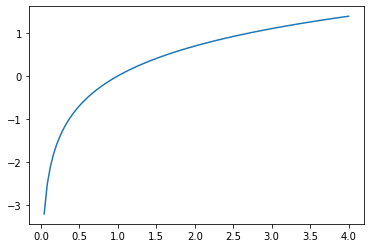

In [56]:
# now we want a bounded output - thats what log is for
plot_function(torch.log, min=0, max=4)

In [76]:
# now we really want to do this with more classes - otherwise we could use sigmoid
random_numbers = torch.randn((4,3))*2
targets = tensor([1, 0, 1, 2])

In [77]:
# our predictions and targets
random_numbers, targets

(tensor([[ 1.9207, -1.1344, -1.1413],
         [ 3.1961,  0.2230, -0.0784],
         [ 2.8223, -1.3112,  1.7152],
         [-3.2540, -2.7903, -0.4774]]),
 tensor([1, 0, 1, 2]))

*Cross entropy = (softmax + log_likelihood)*

In [89]:
# manual steps
sm_numbers = torch.log_softmax(random_numbers, dim=1)
negative_log_loss = F.nll_loss(sm_numbers, targets, reduction='none')
negative_log_loss.mean()

tensor(1.9526)

In [101]:
# or with functional interface or pytorch class
F.cross_entropy(random_numbers, targets), \
nn.CrossEntropyLoss()(random_numbers, targets)

(tensor(1.9526), tensor(1.9526))

Once again all the steps

In [92]:
# taking the softmax to sum to 1
sm_numbers = torch.log_softmax(random_numbers, dim=1)
sm_numbers

tensor([[-0.0898, -3.1448, -3.1517],
        [-0.0852, -3.0583, -3.3597],
        [-0.2975, -4.4311, -1.4046],
        [-2.9261, -2.4623, -0.1495]])

In [97]:
# (or taking the log separately)
sm_numbers = torch.softmax(random_numbers, dim=1)
sm_numbers = sm_numbers.log()
sm_numbers

tensor([[-0.0898, -3.1448, -3.1517],
        [-0.0852, -3.0583, -3.3597],
        [-0.2975, -4.4311, -1.4046],
        [-2.9261, -2.4623, -0.1495]])

In [98]:
# taking the negative log loss (which does not actually take the log 
# but assumes you have done it before)
negative_log_loss = F.nll_loss(sm_numbers, targets, reduction='none')
negative_log_loss

tensor([3.1448, 0.0852, 4.4311, 0.1495])

In [99]:
# taking the mean
negative_log_loss.mean()

tensor(1.9526)

### Model Interpretation